In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import kmeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


caminho_arquivo = r'C:\Users\Natan\OneDrive\Documents\Victor-projects\data projects\churn_telco\churn_telco\data\interim\dados_limpos_telco.xlsx'
df = pd.read_excel(caminho_arquivo)
df



,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,No opinion
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,No opinion
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,No opinion
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,No opinion


In [2]:
# printando valores sem "No opinion"
df_filtered = df[df["Churn Reason"] != "No opinion"].copy()

# Após remover valores "No opinion" vamos verificar quantas linhas temos no DF
quantity_filtered = df_filtered.shape[0]
print("Clientes com feedback definido: ", quantity_filtered)

#Calculando os 15% para a diminuição
goal_reduct = quantity_filtered * 0.15
print(f"Meta definida de redução: {goal_reduct:.0f} clientes")

# portanto, temos 1869 clientes com feedback definido. O nosso objetivo é diminuir a quantidade de churn em até 280 clientes


Clientes com feedback definido:  1869
Meta definida de redução: 280 clientes


In [3]:
print(df.columns)

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')


In [4]:
print(df_filtered["Churn Reason"].value_counts())


print("")
print("Motivo mais conhecido é o serviço de atendimento ao cliente(SAC)")

# Analisando mais profundamente a partir dos clientes que reclamaram do SAC
df_sac = df_filtered[df_filtered["Churn Reason"] == "Attitude of support person"].copy()

# analisando o score de churn na questão do atendimento ao cliente
print(df_sac["Churn Score"].dtype)

df_sac_churn_score = df_sac[df_sac["Churn Score"] >= 70]

print("Churn Score médio de quem reclamou do SAC:", df_sac["Churn Score"].mean())
print("Quantidade com score acima de 70:", df_sac_churn_score.shape[0])
print(df_sac_churn_score.describe())

# Podemos nos deparar com muitos problemas voltados ao SAC
# Em uma escala de 0 à 100 a média de churn é 82.04(uma média bem alta)
# Temos também 163 clientes que marcaram o score acima de 70
# Além disso, interpretando Tenure Months como tempo como clientes, temos uma média de 18.75 meses. O que é menos de 2 anos
# Em CLTV temos como valor total estimado do cliente. Outro dado muito importante, explicando quanto a empresa perde a cada cliente que cancela o serviço
print()
print("- Os clientes que reclamaram do SAC e tinham Churn Score alto")
print("- Clientes tinham em média menos de 2 anos de contrato")
print("- Pagavam em torno de $73 por mês")
print("- E representavam um alto valor estimado para a empresa (CLTV médio de $4164)")
print("- Score médio de 84, muitos deles estavam prontos para sair. Melhorar o SAC não é só questão de experiência do cliente, é uma jogada de salvar receita real.")


Churn Reason
Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Lack of affordable download/upload speed      44
Limited range of services                     44
Long distance charges                         44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: c

In [5]:
# comparando a média de score de churn de problemas com o SAC com a média de score de outros churn

# Segundo maior motivo de churn tem relação com qualidade do serviço, no caso, a concorrência oferece planos com maiores velocidades de download
churn_download_speed = df_filtered[df_filtered["Churn Reason"] == "Competitor offered higher download speeds"].copy()

df_download_speed_churn_score = churn_download_speed[churn_download_speed["Churn Score"] >= 70]
print("Churn médio sobre pessoas que reclamaram da velocidade da internet: ", df_download_speed_churn_score["Churn Score"].mean())
print("Quantidade com score acima de 70:", df_download_speed_churn_score.shape[0])

print("Resultados ainda piores do que as analises anteriores, e também já conseguimos ultrapassar os 15% de churn apenas com essas duas analises")
print("Além de investimentos na qualidade do atendimento, a empresa precisa realizar fortes ações de investimentos em melhorias de desempenho")
print("Seria eficiente trabalhar com melhorias e com o time de marketing para anunciar maiores velocidades posteriormente para seus clientes")
print()
print(df_download_speed_churn_score.describe())


Churn médio sobre pessoas que reclamaram da velocidade da internet:  85.3433734939759
Quantidade com score acima de 70: 166
Resultados ainda piores do que as analises anteriores, e também já conseguimos ultrapassar os 15% de churn apenas com essas duas analises
Além de investimentos na qualidade do atendimento, a empresa precisa realizar fortes ações de investimentos em melhorias de desempenho
Seria eficiente trabalhar com melhorias e com o time de marketing para anunciar maiores velocidades posteriormente para seus clientes

       Count      Zip Code    Latitude   Longitude  Tenure Months  \
count  166.0    166.000000  166.000000  166.000000     166.000000   
mean     1.0  93739.746988   36.326767 -119.877568      19.656627   
std      0.0   1737.454888    2.489080    2.363429      20.390346   
min      1.0  90013.000000   32.671170 -124.240051       1.000000   
25%      1.0  92241.500000   34.085686 -121.943632       3.000000   
50%      1.0  93815.500000   36.557613 -120.387793    

In [6]:
# O terceiro e ultimo motivo que vamos analisar será que a concorrência oferece maiores pacotes de dados

churn_data = df_filtered[df_filtered["Churn Reason"] == "Competitor offered more data"].copy()
churn_data_mean = churn_data[churn_data["Churn Score"] >= 70]
print("Média de pessoas que alegam maior quantidade de dados em empresas rivais: ", churn_data_mean["Churn Score"].mean())
print("Quantidade de pessoas que alegam maior quantidade de dados em outras empresas: ", churn_data_mean.shape[0])
print()
print(churn_data_mean.describe())

Média de pessoas que alegam maior quantidade de dados em empresas rivais:  84.6962962962963
Quantidade de pessoas que alegam maior quantidade de dados em outras empresas:  135

       Count      Zip Code    Latitude   Longitude  Tenure Months  \
count  135.0    135.000000  135.000000  135.000000     135.000000   
mean     1.0  93899.577778   36.780421 -120.200361      18.614815   
std      0.0   1807.165776    2.360327    2.198432      19.557029   
min      1.0  90019.000000   32.605012 -124.217378       1.000000   
25%      1.0  92590.000000   34.319741 -121.968077       3.500000   
50%      1.0  94403.000000   37.305622 -120.853288      10.000000   
75%      1.0  95464.500000   38.486720 -118.262006      30.000000   
max      1.0  96088.000000   41.950683 -114.192901      71.000000   

       Monthly Charges  Churn Value  Churn Score         CLTV  
count       135.000000        135.0   135.000000   135.000000  
mean         76.912222          1.0    84.696296  4215.051852  
std      

In [7]:
print(df.columns)

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')


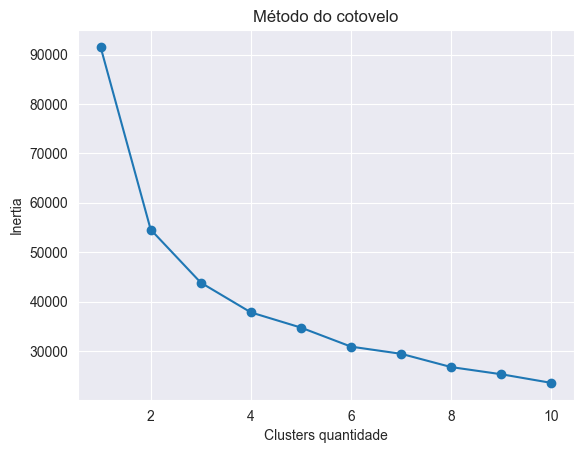

         Tenure Months  Monthly Charges         CLTV
Cluster                                             
0            30.547182        21.079194  4374.382045
1            55.002642        84.207067  4972.638485
2            17.394948        71.693007  4012.049908


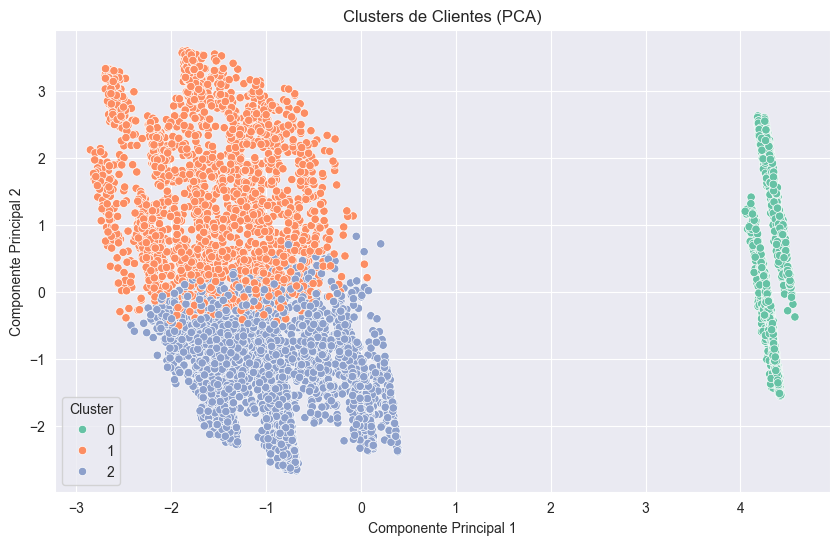

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# iniciando estudos com clustering para criar campanhas de marketing direcionadas

# separando colunas que vão ser usadas para a analise

selected_cols = df[['Tenure Months', 'Monthly Charges', 'CLTV', 'Online Security', 'Tech Support', 'Streaming Movies', 'Internet Service', 'Contract']]

df_model = selected_cols.copy()


# convertendo variaveis categóricas para numéricas
df_model = pd.get_dummies(df_model, drop_first=True)

# imputação e escalonamento
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_model)

# normalizando dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# selecionando numero de clusters+
inertia = []
for k in range(1, 11):
	kmeans = KMeans(n_clusters=k, random_state=42)
	kmeans.fit(X_scaled)
	inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Clusters quantidade')
plt.ylabel('Inertia')
plt.title('Método do cotovelo')
plt.grid(True)
plt.show()

# treinando modelo kmeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

df_model['Cluster'] = cluster_labels

# analise dos grupos formados
cluster_summary = df_model.groupby('Cluster')[['Tenure Months', 'Monthly Charges', 'CLTV']].mean()
print(cluster_summary)

# visualização 2d
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_model['Cluster'], palette='Set2')
plt.title('Clusters de Clientes (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [9]:
print(cluster_summary)



         Tenure Months  Monthly Charges         CLTV
Cluster                                             
0            30.547182        21.079194  4374.382045
1            55.002642        84.207067  4972.638485
2            17.394948        71.693007  4012.049908


In [13]:

# ------------- Interpretação dos clusters ----------------


# Cluster 0: "Conservadores"
# Clientes com tempo médio de contrato (~30 meses) e baixo gasto mensal (~R$21).
# CLTV (Customer Lifetime Value) também é relativamente baixo.
# Interpretação: clientes de perfil básico, com poucos serviços ativos ou plano essencial.
# Estratégia recomendada: oferecer upgrades de planos com descontos iniciais e pacotes mais vantajosos.
# Meta: aumentar o ticket médio sem perder a base.

# Cluster 1: "Fidelidade Premium"
# Clientes extremamente fidelizados (~55 meses), com o maior gasto mensal (~R$84).
# CLTV é o mais alto entre os grupos, mas ainda proporcional ao tempo de casa.
# Interpretação: já consomem bastante, talvez próximos do limite do que a empresa oferece.
# Estratégia ideal: descontos e programas por tempo de fidelidade, vantagens exclusivas, benefícios por tempo de contrato
# Meta: manter esse grupo fiel e transformá-los em promotores da marca.

# Cluster 2: "Novatos de Alto Potencial"
# Clientes recentes (~17 meses), mas com gasto mensal elevado (~R$71).
# CLTV ainda baixo por tempo de casa, mas com forte potencial de crescimento.
# Interpretação: são novos, mas já demonstram engajamento e valor.
# Estratégia recomendada: retenção e encantamento — oferecer bônus, serviços premium grátis por tempo limitado para formar mais clientes fiéis.
# Meta: fidelizar esse grupo antes que considerem churn.

# Esses insights podem ser usados para personalizar campanhas de marketing